# Project 03 - 3D reconstruction

__Handout date:__ 27.06.2024      
__Submission date:__ 18.07.2023 - 23:59
__Submission link:__ https://fz-juelich.sciebo.de/s/rVa2i83BrBmyaJ8


In this project, you will work on 3D reconstruction from stereo data.
You will estimate disparity maps from rectified images, and resolve inconsistencies in the results using graphical models.

For this task, you will use the [2014 Stereo Datasets](https://vision.middlebury.edu/stereo/data/scenes2014/).
The dataset contains rectified images and serves as a benchmark for depth estimation from stereo images.

1. Download the dataset and inspect its structure.
1. Choose at least two images from the dataset to work with. For the beginning, work with the default images (no variation in lightning or exposure).
1. Use the methods discussed in the lecture to compute the disparity between the two images, which involves:
    1. Scanline approach to identify matching pixels using an appropriate similarity metric.
    1. Cross-checking using reverse scanline.
    1. Resolution of ambiguous matches.
1. Use the computed disparity to estimate the depth.
1. Repeat the above steps using the provided images with varying lightning and exposure.
1. Use a Markov Random Field (MRF) to resolve holes and inaccuracies in the computed disparity maps.
    1. Install [gco-wrapper](https://github.com/Borda/pyGCO) using `pip install gco-wrapper`.
    1. Convert the task of smoothing the disparity map into a MRF problem. In particular, think about how labels can be defined for this task (tip: maximum disparity).
    1. Use `cut_grid_graph` or `cut_grid_graph_simple` to solve the defined MRF.
1. Recompute the depth map using your corrected disparity maps and compare them to the previous result. Repeat the analysis for your selected images under different lightning and exposure.

__Tip:__ Do not replicate your code, use functions to repeat the analysis on different image pairs.

In [3]:
import cv2
import numpy as np
img0_g = cv2.imread('./im0.png', 0)
img1_g = cv2.imread('./im1.png', 0)
l,w = img0_g.shape

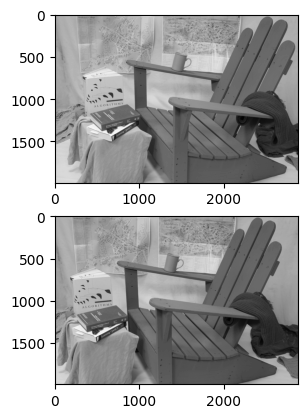

In [ ]:
import matplotlib.pyplot as plt
ax1 = plt.subplot(211)
ax1.imshow(img0_g, cmap='gray')
ax2 = plt.subplot(212, sharex=ax1)
ax2.imshow(img1_g, cmap='gray')

In [4]:
def stereo_matching(limg, rimg, dmax, w_size):
    l_img = np.pad(limg, [(w_size, w_size), (w_size, w_size)], mode='edge')
    r_img = np.pad(rimg, [(w_size, w_size), (w_size + dmax, w_size)], mode='edge')

    length, width = l_img.shape
    diff = np.zeros((length, width, dmax))
    d = np.zeros_like(l_img)

    for i in range(0, dmax):
      I_L = l_img[:,0: width]
      I_R = r_img[:, i: width + i]
      d = np.square(I_L - I_R)/(length*width)
      d_p = np.zeros_like(l_img).astype(float)
      for x in range(w_size, length - w_size):
        for y in range(w_size, width - w_size):
          d_p[x-w_size, y-w_size] = np.sum(d[x-w_size:x+w_size, y-w_size:y+w_size])
      diff[:, :, i] = d_p

    dbest = np.argmin(diff, axis=2)
    return dbest

In [5]:
test = stereo_matching(img0_g, img1_g, 30, 3)

In [6]:
testr = stereo_matching(img1_g, img0_g, 30, 3)

In [7]:
def left_right_consistency(disparity_map_left: np.ndarray, disparity_map_right: np.ndarray) -> np.ndarray:
    """Perform left-right consistency check."""
    check = np.zeros_like(disparity_map_left)
    for y in range(disparity_map_left.shape[0]):
        for x in range(disparity_map_left.shape[1]):
            if (x - disparity_map_left[y, x]) >= 0 and ((x - disparity_map_left[y, x]) < disparity_map_left.shape[1]):
                check[y, x] = abs(disparity_map_left[y, x] - disparity_map_right[y, x - disparity_map_left[y, x]])<1
    return check

In [10]:
cross_check = left_right_consistency(test, testr)

In [11]:
cross_check.shape, np.sum(cross_check), 2994*2886

((1994, 2886), 286253, 8640684)

In [22]:
l, w = cross_check.shape
test1 = np.zeros_like(test)
for i in range(l):
  for j in range(w):
    if cross_check[i, j] == 1:
      test1[i, j] = test[i, j]
    else:
      test1[i, j]= 0

In [30]:
#Estimate depth by the computed disparity with equation Z = baseline * f / (d + doffs)
doffs=209.059
baseline=176.252
f=4161.221
Z = baseline*f/(test + doffs)

In [31]:
#Estimate disparity and depth with varing lightening
img1l_g = cv2.imread('./im1L.png', 0)

In [32]:
test_l = stereo_matching(img0_g, img1l_g, 30, 3)

In [33]:
#Estimate disparity and depth with different exposure
img1e_g = cv2.imread('./im1E.png', 0)

In [34]:
test_e = stereo_matching(img0_g, img1e_g, 30, 3)

In [68]:
pip install gco-wrapper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.0/243.0 kB 4.9 MB/s eta 0:00:00


In [70]:
from gco import cut_grid_graph_simple

/usr/local/lib/python3.10/dist-packages/gco/__init__.py:7: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, name):


In [31]:
import pandas as pd
r_ind = [x for x in range(test1.shape[0])]
c_ind = [y for y in range(test1.shape[1])]
df = pd.DataFrame(data= cross_check,index= r_ind,columns=c_ind)
df.to_csv("./cross_check.csv")